In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, BertModel, AutoModelForSequenceClassification
from transformers import pipeline
import torch 
import transformers
import numpy
from matplotlib import pyplot as plt
from dataset_extractor import *
tokenizer=AutoTokenizer.from_pretrained('bert-base-chinese')
model_cls=AutoModelForSequenceClassification.from_pretrained('bert-base-chinese',num_labels=202)


/data/chenhaohua/.conda/envs/dl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /data/chenhaohua/PRC_legal/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
import json as js
sentence="你今天吃了吗"
tokens=tokenizer(sentence)
print(tokens)

{'input_ids': [101, 872, 791, 1921, 1391, 749, 1408, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [3]:

%matplotlib inline
import numpy as np
train_pair=extract("/data/chenhaohua/PRC_legal_dataset/data_train.json")

123216 lines have been extracted


苏州市吴中区被告人张某于6月7日下午伙同他人经事先预谋至苏州市吴中区木渎镇尧峰公墓尧峰石材厂附近一个枇杷园的民房中持木棍殴打被害人吴某等人致被害人吴某左手臂受伤经法医鉴定被害人吴某因外伤致左尺骨干中下段骨折属人体轻伤二级公诉机关为证实上述事实提供了有关证据公诉机关认为被告人张某的行为已触犯中华人民共和国刑法××××之规定构成××罪并系主犯 0
123216


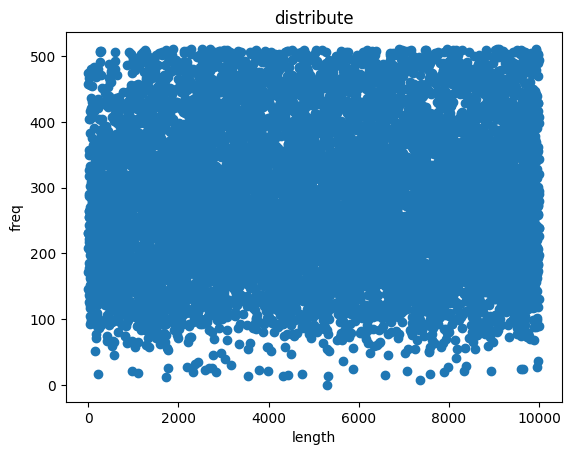

In [4]:
string_lengths = [len(s) for s in train_pair["content"]]
count=sum([1 for s in train_pair["content"] if len(s) < 512])
max_length = np.argmax(string_lengths[:1000])
print(train_pair["content"][250],train_pair["label"][250])
plt.scatter(range(10000),string_lengths[:10000])
plt.xlabel('length')
plt.ylabel('freq')
plt.title('distribute')
print(count)

In [5]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
batch_size=40
train_batch=tokenizer(train_pair["content"],max_length=512,truncation=True,padding="max_length",return_tensors="pt")
train=TensorDataset(train_batch["input_ids"],train_batch["attention_mask"],torch.tensor(train_pair["label"]))
train_sampler=RandomSampler(train)
train_dataloader=DataLoader(train,sampler=train_sampler,batch_size=batch_size)
from torch.optim import AdamW
optimizer=AdamW(model_cls.parameters(),lr=2e-5)
num_epochs=8
from transformers import get_scheduler
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [6]:
device=torch.device("cuda",2)
def train(model):
    model.to(device)
    for epoch in range(num_epochs):
        model.train() #切换成训练模式
        total_loss=0
        for step,batch in enumerate(train_dataloader):
            if step % 10 == 0 and not step == 0:
                print("step: ",step, "  loss:",total_loss/(step*batch_size))
            b_input_ids=batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()
            outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
            loss = outputs.loss     # include cross-entropy loss   
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #防止梯度爆炸
            optimizer.step()
            lr_scheduler.step()
        avg_train_loss = total_loss / len(train_dataloader)      
        print("avg_loss:",avg_train_loss)
        model.save_pretrained(f"bert-base-legal-chinese-epoch-{epoch+1}")


In [7]:
train(model_cls)

step:  10   loss: 0.13473873496055602
step:  20   loss: 0.13123830378055573
step:  30   loss: 0.12935192584991456
step:  40   loss: 0.12765939563512801
step:  50   loss: 0.1259733762741089
step:  60   loss: 0.12401915490627288
step:  70   loss: 0.1221181445462363
step:  80   loss: 0.1203584523499012
step:  90   loss: 0.11853059338198768
step:  100   loss: 0.1170929417014122
step:  110   loss: 0.11524706428701227
step:  120   loss: 0.11332564160227776
step:  130   loss: 0.11138104172853323
step:  140   loss: 0.10953806106533323
step:  150   loss: 0.10780677592754365
step:  160   loss: 0.10635155104100705
step:  170   loss: 0.10469241009039038
step:  180   loss: 0.10312526408169005
step:  190   loss: 0.10150425481168847
step:  200   loss: 0.10003975507616997
step:  210   loss: 0.09867866291886285
step:  220   loss: 0.09718225858428262
step:  230   loss: 0.09566617359285769
step:  240   loss: 0.09420903404553731
step:  250   loss: 0.09297080774307251
step:  260   loss: 0.0916501201574619
